In [200]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.image import NonUniformImage
import matplotlib.ticker as ticker
from matplotlib import cm
import os, time, sys
import struct
import scipy.interpolate as interp
import scipy.integrate as integrate
import astropy.constants as const
import astropy.units as u
from astropy.cosmology import z_at_value
from astropy.cosmology import WMAP9 as cosmo
from fractions import Fraction

import StrainandNoise as SnN

# Directory Names

In [202]:
top_directory = os.getcwd()
LISA_Other_filedirectory = top_directory + '/LoadFiles/InstrumentStrainFiles/LISA_Other/'
LISA_Neil_filedirectory = top_directory + '/LoadFiles/InstrumentStrainFiles/LISA_Neil/'
LISA_ESA_filedirectory = top_directory + '/LoadFiles/InstrumentStrainFiles/LISA_ESA/'
ET_filedirectory = top_directory + '/LoadFiles/InstrumentStrainFiles/EinsteinTelescope/'
aLIGO_filedirectory = top_directory + '/LoadFiles/InstrumentStrainFiles/aLIGO/'
NANOGrav_filedirectory = top_directory + '/LoadFiles/InstrumentStrainFiles/NANOGrav/' 

# Constants and Initial Parameters

In [203]:
#Selects contour levels to separate sections into
contLevels = np.array([10, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
axissize = 14
labelsize = 16
legendsize = 12
textsize = 11
textcolor = 'k'
linesize = 4
figsize = (10,8)

contourcolorPresent = 'plasma'
transparencyPresent = 1.0
contourcolorFuture = 'plasma'
transparencyFuture = 1.0
colornorm = colors.Normalize(vmin=0.0, vmax=5.0)


'''
    Indices: 
        0 - Mass (Solar Units)
        1 - Mass Ratio
        2 - Spin1
        3 - Spin2
        4 - Redshift
'''

index1 = 4 #Variable on y-axis
sampleRate1 = 100 #Number of SNRMatrix rows

index2 = 0 #Variable on x-axis
sampleRate2 = 100 #Number of SNRMatrix columns

#Selects which noise curve: 0 is Neil's,
# 							1 is the 2016 proposal,
#							2 is Einstein Telescope, 
#							3 is aLIGO, 
#							4 is NANOGrav 11yr,
#							5 is SKA (2030s),
#							anything else is the L3 proposal
model = 5


#M = m1+m2 Total Mass
M = 1e6
M_min = 1e1
M_max = 1e12

#q = m2/m1 reduced mass
q = 1
q_min = 1
q_max = 18

#Chi = S_i*L/m_i**2, spins of each mass i
chi1 = 0.0 #spin of m1
chi2 = 0.0 #spin of m2
chi_min = -0.85 #Limits of PhenomD for unaligned spins
chi_max = 0.85

z = 3.0 #Redshift
z_min = 1e-2
z_max = 1e3

nfreqs = int(1e3)   #Sample rate of strain/Transfer function frequencies

initVarArray = np.array([M, q, chi1, chi2, z])
VarArray = initVarArray

VarLims = np.array([[M_min, M_max], [q_min, q_max], [chi_min, chi_max], [chi_min, chi_max], [z_min, z_max]])
VarNames = np.array(['M','q','chi1','chi2','z'])

# Model Selection

In [204]:
if model == 0: #Neil
    T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
    #Neil Calculation from https://arxiv.org/pdf/1803.01944.pdf
    Neil_S_acc = 3e-15*u.m/u.s/u.s #M/sqrt(Hz)
    Neil_S_oms = 1.5e-11*u.m
    Neil_L = 2.5e9*u.m
    fT,LISA_Transfer_Function = SnN.Get_TransferFunction(L=Neil_L)    
    S_n_f_sqrt = SnN.NeilSensitivity(f,LISA_Transfer_Function)
    S_n_f_sqrt = S_n_f_sqrt/(u.Hz)**Fraction(1,2)
elif model == 1: #Martin 2016
    T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
    #LISA Calculation without pathfinder correction (2016 model)
    Ssci = 8.9e-12**2*u.m*u.m
    Sloc = 1.7e-12**2*u.m*u.m
    Sother = 2e-12**2*u.m*u.m
    k2016_P_ims = Ssci+2*Sloc+Sother
    k2016_L = 2.5e9*u.m
    fT,LISA_Transfer_Function = SnN.Get_TransferFunction(L=k2016_L)
    k2016_P_acc = ((1.8e-14*u.m/u.s/u.s)**2*((3e-5*u.Hz/f)**10 + (1e-4*u.Hz/f)**2) + (3e-15*u.m/u.s/u.s)**2)/(2*np.pi*f)**4   #red below 1e-4, white above
    S_n_f_sqrt = SnN.calcASD(f,LISA_Transfer_Function,k2016_P_acc,k2016_P_ims,k2016_L)
    S_n_f_sqrt = S_n_f_sqrt/(u.Hz)**Fraction(1,2)
elif model == 2: #Einstein Telescope
    T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
    ET_filename = 'ET_D_data.txt'
    ET_filelocation = ET_filedirectory + ET_filename
    ET_data = np.loadtxt(ET_filelocation)
    fT = ET_data[:,0]*u.Hz
    S_n_f_sqrt = ET_data[:,1]
    S_n_f_sqrt = S_n_f_sqrt/(u.Hz)**Fraction(1,2)
elif model == 3: #aLIGO
    T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
    aLIGO_filename = 'aLIGODesign.txt'
    aLIGO_filelocation = aLIGO_filedirectory + aLIGO_filename
    aLIGO_data = np.loadtxt(aLIGO_filelocation)
    #Cheating with names so I don't have to load data everytime
    fT = aLIGO_data[:,0]*u.Hz
    S_n_f_sqrt = aLIGO_data[:,1]
    S_n_f_sqrt = S_n_f_sqrt/(u.Hz)**Fraction(1,2)
elif model == 4: #NANOGrav 11 yr
    ###############################################
    #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
    deltrms_nano = 100*u.ns #rms timing residuals in seconds
    deltrms_nano = deltrms_nano.to('s')

    T_obs = 11.4*u.yr #Observing time in years
    T_obs = T_nano.to('s') #Observing time in seconds
    Np_nano = 45 #Number of pulsars
    cadence_nano = 1/(2*u.wk) #Avg observation cadence of 1 every 2 weeks in seconds
    cadence_nano = cadence_nano.to('1/s')
    ndetectors = 1
    fT,S_n_f_sqrt = SnN.calcPTAASD(deltrms_nano,cadence_nano,T_obs,ndetectors)
elif model == 5: #SKA (2030s)
    ###############################################
    #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
    deltrms_nano = 100*u.ns #rms timing residuals in seconds
    deltrms_nano = deltrms_nano.to('s')

    T_nano = 11.4*u.yr #Observing time in years
    T_nano = T_nano.to('s') #Observing time in seconds
    Np_nano = 45 #Number of pulsars
    cadence_nano = 1/(2*u.wk) #Avg observation cadence of 1 every 2 weeks in seconds
    cadence_nano = cadence_nano.to('1/s')
    
    ###############################################
    #SKA calculation using parameters and methods from arXiv:0804.4476 section 7.1
    deltrms_SKA = 20*u.ns #rms timing residuals in nanoseconds
    deltrms_SKA = deltrms_SKA.to('s')

    T_SKA = 15*u.yr #Observing time in years
    T_SKA = T_SKA.to('s') #Observing time in seconds

    Np_SKA = 20 #Number of pulsars
    cadence_SKA = 1/u.wk #Avg observation cadence of 1 every week in seconds
    cadence_SKA = cadence_SKA.to('1/s')
    
    ndetectors = 2
    T_obs_full = [T_nano, T_SKA]
    cadence_full = [cadence_nano, cadence_SKA]
    sigma_rms_full = [deltrms_nano, deltrms_SKA]
    
    T_obs=T_nano+T_SKA

    fT,S_n_f_sqrt = SnN.calcPTAASD(sigma_rms_full,cadence_full,T_obs_full,ndetectors)
else: #L3 proposal
    T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
    S_acc_low_knee = .4*u.mHz
    S_acc_high_knee = 8.*u.mHz
    S_oms_knee = 2.*u.mHz
    ESA_L = 2.5e9*u.m
    fT,LISA_Transfer_Function = SnN.Get_TransferFunction(L=ESA_L)
    S_n_f_sqrt = SnN.LisaSensitivity(fT,LISA_Transfer_Function)
    S_n_f_sqrt = S_n_f_sqrt/(u.Hz)**Fraction(1,2)

Adding Astropy units

In [205]:
print(T_obs.unit)
print(fT.unit)
print(S_n_f_sqrt.unit)

s
Hz
Hz s(3/2)


In [206]:
phenomD_f,phenomD_h = SnN.Get_Waveform(initVarArray)
phenomD_f,phenomD_h = SnN.StrainConv(initVarArray,phenomD_f,phenomD_h)
print(initVarArray)

[1.e+06 1.e+00 0.e+00 0.e+00 3.e+00]


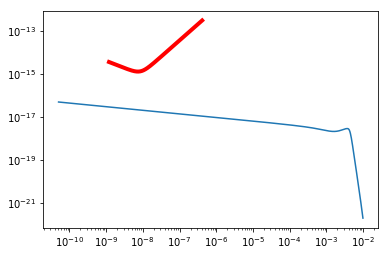

In [207]:
plt.figure()
plt.loglog(fT,np.sqrt(fT)*S_n_f_sqrt, linewidth = linesize,color = cm.hsv(colornorm(0.0)))
plt.loglog(phenomD_f,np.sqrt(4*phenomD_f**2*phenomD_h**2))
plt.show()

# Setting Up SNR Calculation
Uses the index given and the data range to sample the space either logrithmically or linearly based on the 
selection of variables. Then it computes the SNR for each value.
Returns the variable ranges used to calculate the SNR for each matrix, then returns the SNRs with size of the sample1Xsample2


# Check frequency evolution

In [208]:
def checkFreqEvol(Vars,T_obs,f_init):
    #####################################
    #If the initial observed time from merger is less than the time observed
    #(ie t_init-T_obs < 0 => f_T_obs is complex),
    #the BBH will or has already merged during the observation
    #If the initial observed time from merger is greater than the time observed
    #(ie t_init-T_obs > 0 => f_T_obs is real),
    #And if the frequency of the binary does evolve over more than one bin,
    #(ie f_T_obs-f_init < 1/T_obs), it is monochromatic,
    #Otherwise it is chirping and evolves over the observation 
    #####################################
    
    [M,q,_,_,z] = np.split(Vars,len(Vars))
    m_conv = const.G*const.M_sun/const.c**3 #Converts M = [M] to M = [sec]
    
    eta = q/(1+q)**2
    M_redshifted_time = M*(1+z)*m_conv
    M_chirp = eta**(3/5)*M_redshifted_time
    
    #f(t) from eqn 24 of Cornish et. al 2018 https://arxiv.org/pdf/1803.01944.pdf
    t_init = 5*(M_chirp)**(-5/3)*(8*np.pi*f_init)**(-8/3)
    f_evolve = 1./8./np.pi/M_chirp*(5*M_chirp/(t_init-T_obs))**(3./8.)
    f_T_obs = 1./8./np.pi/M_chirp*(5*M_chirp/(T_obs))**(3./8.)
    
    if (f_evolve-f_init) < (1/T_obs) and (t_init-T_obs) > 0:
        return f_init, True
    else:
        return f_T_obs, False

## getSNRMatrixVer8
Mixed initial observing frequencies and time from merger

In [209]:
def getSNRMatrixVer8(Var1index,sampleRate1,Var2index,sampleRate2,Vars,VarLims,fT,S_n_f_sqrt,T_obs):
    recalculate = False #Assume we only need to calculate the waveform once

    [phenomD_f,phenomD_h] = SnN.Get_Waveform(Vars)
    
    f_opt = fT[np.argmin(S_n_f_sqrt)]

    if Var1index == 1 or Var1index == 2 or Var1index == 3:
        #Sample in linear space for mass ratio and spins
        sample1 = np.linspace(VarLims[Var1index,0],VarLims[Var1index,1],sampleRate1)
        recalculate = True #Must recalculate the waveform at each point
    else:
        #Sample in log space for any other variables
        sample1 = np.logspace(np.log10(VarLims[Var1index,0]),np.log10(VarLims[Var1index,1]),sampleRate1)

    if Var2index == 1 or Var2index == 2 or Var2index == 3:
        #Sample in linear space for mass ratio and spins
        sample2 = np.linspace(VarLims[Var2index,0],VarLims[Var2index,1],sampleRate2)
        recalculate = True #Must recalculate the waveform at each point
    else:
        #Sample in log space for any other variables
        sample2 = np.logspace(np.log10(VarLims[Var2index,0]),np.log10(VarLims[Var2index,1]),sampleRate2)

    sampleSize1 = len(sample1)
    sampleSize2 = len(sample2)
    SNRMatrix = np.zeros((sampleSize1,sampleSize2))

    for i in range(sampleSize1):
        for j in range(sampleSize2):
            Vars[Var1index] = sample1[i]
            Vars[Var2index] = sample2[j]
            #if ismono f_init=f_opt, else f_init=f_T_obs
            f_init, ismono = checkFreqEvol(Vars,T_obs,f_opt)
            SNRMatrix[i,j] = calcSNRVer11(Vars,phenomD_f,phenomD_h,fT,S_n_f_sqrt,T_obs,f_init,recalculate,ismono)
    return [sample1,sample2,SNRMatrix]

# Calculation of SNR

# calcSNRver11

In [210]:
def calcSNRVer11(Vars,phenomD_f,phenomD_h,fT,S_n_f_sqrt,T_obs,f_init,recalculate,ismono):
    
    
    S_n_f = S_n_f_sqrt**2 #Amplitude Spectral Density
    
    if ismono:
        indxfgw,h_gw = SnN.Get_MonoStrain(Vars,fT,f_init,T_obs)
        #CALCULATE SNR
        SNR = np.sqrt(h_gw**2/S_n_f[indxfgw])[0]
    else:
        #Source is either evolving during the observation (f_T_obs-f_obs)>(1/T_obs),
        #or Completely Merges during the observation,
        #or already merged (Tobs > tinit => imaginary f_T_obs)  
        if recalculate:
            [phenomD_f,phenomD_h] = SnN.Get_Waveform(Vars)
        
        phenomD_f,phenomD_h = SnN.StrainConv(Vars,phenomD_f,phenomD_h)
        #Only want to integrate from observed frequency till merger
        indxfgw = np.abs(phenomD_f-f_init).argmin()
        if indxfgw >= len(phenomD_f)-1:
            #If the SMBH has already merged set the SNR to ~0
            return 1e-30  
        else:
            f_cut = phenomD_f[indxfgw:]
            h_cut = phenomD_h[indxfgw:]

        #################################
        #Interpolate the Strain Noise Spectral Density to only the frequencies the
        #strain runs over
        #Set Noise to 1e30 outside of signal frequencies
        S_n_f_interp_old = interp.interp1d(np.log10(fT.value),np.log10(S_n_f.value),kind='cubic',fill_value=30.0, bounds_error=False) 
        S_n_f_interp_new = S_n_f_interp_old(np.log10(f_cut.value))
        S_n_f_interp = 10**S_n_f_interp_new

        #CALCULATE SNR FOR BOTH NOISE CURVES
        denom = S_n_f_interp #Sky Averaged Noise Spectral Density
        numer = f_cut*h_cut**2

        integral_consts = 16/5 # 4 or(4*4/5) from sky/inclination/polarization averaging

        integrand = numer/denom
        SNRsqrd = integral_consts*np.trapz(integrand.value,np.log(f_cut.value),axis=0) #SNR**2
        SNR = np.sqrt(SNRsqrd)
    return SNR

# Plot SNR

In [211]:
def plotSNR(sample1,sample2,SNRMatrix,contLevels,VarLims,VarNames,index1,index2,figsize):
    '''Plots the SNR contours from calcSNR'''
    colormap = 'viridis'
    logLevels = np.log10(contLevels)
    logSNR = np.log10(SNRMatrix)
    xlabel_min = VarLims[index2,0]
    xlabel_max = VarLims[index2,1]
    ylabel_min = VarLims[index1,0]
    ylabel_max = VarLims[index1,1]

    #########################
    #Make the Contour Plots
    fig1, ax1 = plt.subplots(figsize=figsize)

    #Set axis scales based on what data sampling we used 
    if (index1 == 1 or index1 == 2 or index1 == 3) and (index2 != 1 and index2 != 2 and index2 != 3):
        CS1 = ax1.contourf(np.log10(sample2),sample1,logSNR,logLevels,cmap = colormap)
        ax1.set_xlim(np.log10(xlabel_min),np.log10(xlabel_max))
        ax1.set_ylim(ylabel_min,ylabel_max)
        x_labels = np.logspace(np.log10(xlabel_min),np.log10(xlabel_max),np.log10(xlabel_max)-np.log10(xlabel_min)+1)
        y_labels = np.range(ylabel_min,ylabel_max,1)
        ax1.set_yticks(y_labels)
        ax1.set_yticklabels(y_labels,fontsize = axissize)
        ax1.set_xticks(np.log10(x_labels))
        ax1.set_xticklabels(np.log10(x_labels),fontsize = axissize)
    elif (index1 != 1 or index1 != 2 or index1 != 3) and (index2 == 1 and index2 == 2 and index2 == 3):
        CS1 = ax1.contourf(sample2,np.log10(sample1),logSNR,logLevels,cmap = colormap)
        ax1.set_xlim(xlabel_min,xlabel_max)
        ax1.set_ylim(np.log10(ylabel_min),np.log10(ylabel_max))
        x_labels = np.range(xlabel_min,xlabel_max,1)
        y_labels = np.logspace(np.log10(ylabel_min),np.log10(ylabel_max),np.log10(ylabel_max)-np.log10(ylabel_min)+1)
        ax1.set_xticks(x_labels)
        ax1.set_xticklabels(x_labels,fontsize = axissize)
        ax1.set_yticks(np.log10(y_labels))
        ax1.set_yticklabels(np.log10(y_labels),fontsize = axissize)
    elif (index1 != 1 or index1 != 2 or index1 != 3) and (index2 != 1 and index2 != 2 and index2 != 3):
        CS1 = ax1.contourf(np.log10(sample2),np.log10(sample1),logSNR,logLevels,cmap = colormap)
        ax1.set_xlim(np.log10(xlabel_min),np.log10(xlabel_max))
        ax1.set_ylim(np.log10(ylabel_min),np.log10(ylabel_max))
        x_labels = np.logspace(np.log10(xlabel_min),np.log10(xlabel_max),np.log10(xlabel_max)-np.log10(xlabel_min)+1)
        y_labels = np.logspace(np.log10(ylabel_min),np.log10(ylabel_max),np.log10(ylabel_max)-np.log10(ylabel_min)+1)
        ax1.set_yticks(np.log10(y_labels))
        ax1.set_yticklabels(np.log10(y_labels),fontsize = axissize)
        ax1.set_xticks(np.log10(x_labels))
        ax1.set_xticklabels(np.log10(x_labels),fontsize = axissize)

    ax1.set_xlabel(r'log $M_{\rm tot}$ $[M_{\odot}]$',fontsize = labelsize)
    ax1.set_ylabel(r'$z$',fontsize = labelsize)
    ax1.yaxis.set_label_coords(-.10,.5)
    #########################
    #Make colorbar
    cbar1 = fig1.colorbar(CS1)
    cbar1.set_label(r'Future Detectors log $SNR$',fontsize = labelsize)
    cbar1.ax.tick_params(labelsize = axissize)

    plt.show()

/Users/andrewkaiser/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


34.63229012489319


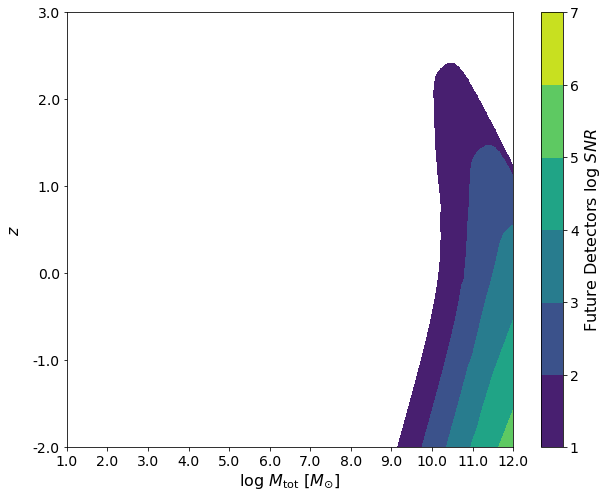

In [212]:
start = time.time()
[sample1,sample2,SNRMatrix] = getSNRMatrixVer8(index1,sampleRate1,index2,sampleRate2,initVarArray,VarLims,fT,S_n_f_sqrt,T_obs)
end = time.time()
print(end-start)
plotSNR(sample1,sample2,SNRMatrix,contLevels,VarLims,VarNames,index1,index2,figsize)

In [215]:
sNRfilename = '/SKASNRMatrix_zvM_correct_3.dat'
samplefilename = '/SKASamples_zvM_correct_3.dat'
isitsavetime = False

In [216]:
if isitsavetime:
    #Save SNR Matrix
    np.savetxt(top_directory+sNRfilename,SNRMatrix)
    #Save Samples
    np.savetxt(top_directory+samplefilename,[sample1,sample2])